# Natural Language Processing with Disaster Tweets

The aim of this competition is to classify tweets into two groups; one category containing mentions of disasters and another category not containing such mentions.

There are many ways in which this can be achieved, the most obvious is using recurrent models such as RNN, GRU and LSTM which is commonly used for text processing. I will be comparing the performance of a few different model architectures.

**Import libraries needed**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

**First we need to do a bit of exploratory data analysis**

Let us have a look at a few examples from each category as well as the distribution of classes.

In [2]:
# Start out by loading the train and test files into Pandas
print('Loading test and training data')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

Loading test and training data


As we can see below the train dataset obviously contain the tweet text itself as well as the target labels. There are also two columns called keyword and location which might be useful. In total there are 7613 samples in the dataset. 

It seems the classes are fairly balanced with a slight overweight of 0-class samples.

There are 61 NaNs in the 'keyword' column and 2533 NaNs in the 'location' column.

In [3]:
print(train_data.describe(include = 'all'))

print(train_data.head(5))

                  id     keyword location  \
count    7613.000000        7552     5080   
unique           NaN         221     3341   
top              NaN  fatalities      USA   
freq             NaN          45      104   
mean     5441.934848         NaN      NaN   
std      3137.116090         NaN      NaN   
min         1.000000         NaN      NaN   
25%      2734.000000         NaN      NaN   
50%      5408.000000         NaN      NaN   
75%      8146.000000         NaN      NaN   
max     10873.000000         NaN      NaN   

                                                     text      target  
count                                                7613  7613.00000  
unique                                               7503         NaN  
top     11-Year-Old Boy Charged With Manslaughter of T...         NaN  
freq                                                   10         NaN  
mean                                                  NaN     0.42966  
std                        

Looking at the first 20 tweets with no keyword there doesn't appear to be any useful pattern to a tweet missing keywords.

If we take a closer look at the keywords and how often they occur we can see that they all look pretty disaster-related.

First 20 tweets with no keyword info:

    id keyword location                                               text  \
0    1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1    4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2    5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3    6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4    7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5    8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6   10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7   13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8   14     NaN      NaN  There's an emergency evacuation happening now ...   
9   15     NaN      NaN  I'm afraid that the tornado is coming to our a...   
10  16     NaN      NaN        Three people died from the heat wave so far   
11  17     NaN      NaN  

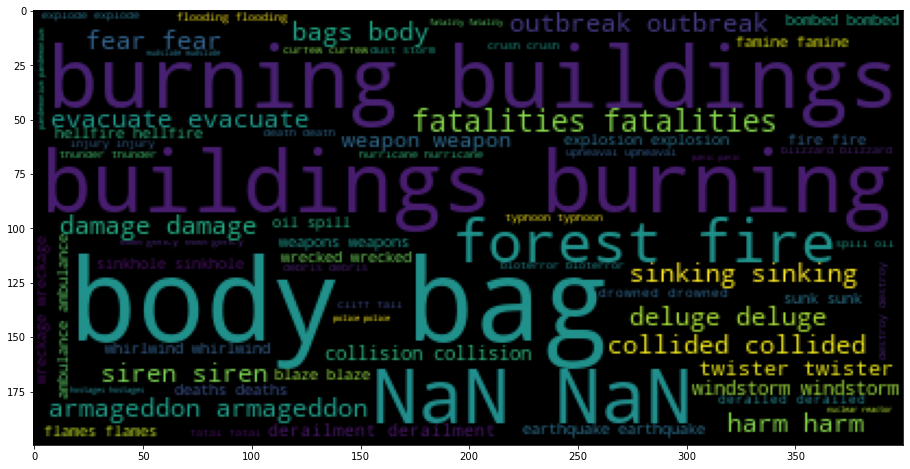

In [4]:
print('First 20 tweets with no keyword info:\n')
print(train_data[train_data['keyword'].isnull()][:20])

print('Word cloud of keywords:\n')
pd.set_option('display.max_rows', None)
#print(train_data.groupby('keyword')['keyword'].count())
wc = WordCloud().generate(str(train_data['keyword']).replace('%20', ' '))
plt.rcParams["figure.figsize"] = (50,8)
plt.imshow(wc)

As we can see below there are a lot of different locations (more than 3000 as we saw above) and most of it does not seem to be very useful. 

We could incorporate the most common locations in the twitter texts but even the most common locations are not occuring often in the texts and seem pretty generic.

In [5]:
print('First 20 tweets with no location info:\n')
print(train_data[train_data['location'].isnull()][:20])

pd.set_option('display.max_rows', None)

print('\nMost commonly occurring locations;')
print(train_data.groupby('location')['location'].count().sort_values().tail(20))

First 20 tweets with no location info:

    id keyword location                                               text  \
0    1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1    4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2    5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3    6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4    7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5    8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6   10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7   13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8   14     NaN      NaN  There's an emergency evacuation happening now ...   
9   15     NaN      NaN  I'm afraid that the tornado is coming to our a...   
10  16     NaN      NaN        Three people died from the heat wave so far   
11  17     NaN      NaN 

Finally let's have a closer look at some of the twitter texts. First a wordcloud with target 0 tweet texts.

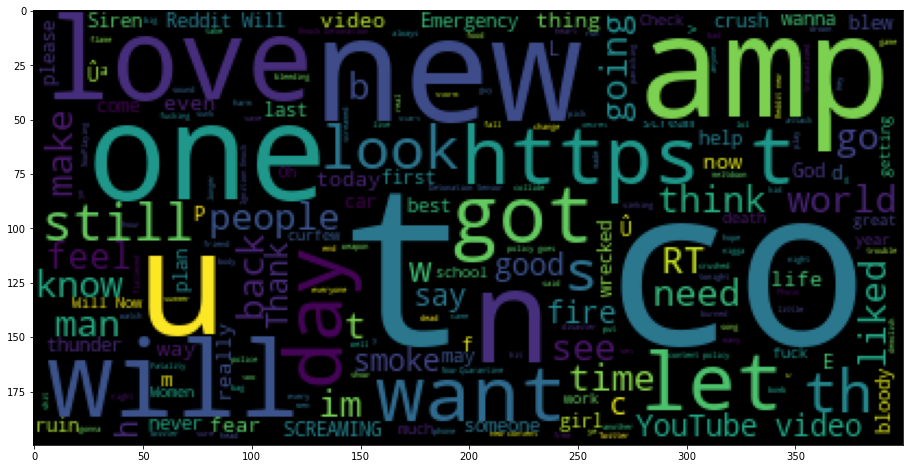

In [6]:
wc = WordCloud().generate(str(train_data[train_data['target'] == 0]['text']).replace('%20', ' '))
plt.rcParams["figure.figsize"] = (50,8)
plt.imshow(wc)

And a wordcloud with taget 1 tweet texts. Looking at the two we can see that there is some difference, even on a single word level which means we should be able to pick a pattern for classification.

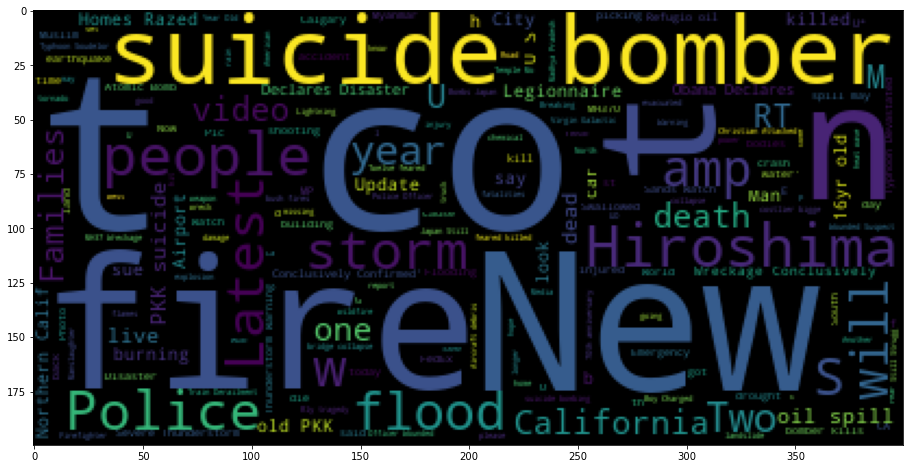

In [7]:
wc = WordCloud().generate(str(train_data[train_data['target'] == 1]['text']).replace('%20', ' '))
plt.rcParams["figure.figsize"] = (50,8)
plt.imshow(wc)

**Define functions for converting the keywords and text to decimal numbers**

Since location does not seem to be overly useful I have decided to skip it. Keyword might be useful however (or it might not) so I will include it if present as the first word in each text.

All texts are vectorized to 50 float values (see next markdown cell for a more detailed description).

In [8]:
def vectorize_tweets(dataframe, df_glove):
    # First create a blank matrix for our word vectors
    vectorized_data = np.zeros((len(dataframe), MAX_TWEET_LENGTH, VECTORS_PER_WORD))
    
    # Now loop thorugh the words and add the corresponding vectors to the matrix
    for index, row in dataframe.iterrows():
        i = 0
        full_text = []
        if str(row['keyword']) != 'nan':
            full_text += str(row['keyword']).replace('%20', ' ').split(' ')
        full_text += re.sub(r'\W+', ' ', row['text'].lower()).split(' ')

        # Remove special characters and convert text to lower case, then split on space
        for word in full_text:
            try:
                vectorized_data[index, i, :] = df_glove.loc[word]
            except KeyError:
                # print(word + ' not found')
                continue
                
            i += 1
            
        # Print a message for every 500 texts processed - just to check if we are still alive
        if index % 500 == 499:
            print('Processing text number ' + str(index + 1) + ' of ' + str(len(dataframe)))
        
    return vectorized_data

**Define a number of different models**

As previously mentioned a recurrent network would be a logical choice for this classification problem due to the sequential format of the input values.<br>
We _could_ one-hot encode the words in the text but since we have more than 7000 fairly long texts of wildly different content it would become a _very_ large and sparse matrix. Using vectorization seems to be the way to go. I have chosen to use the GloVe50 ( https://nlp.stanford.edu/projects/glove/ ) values which I feel are a good balance between containing sufficent information for each word and not resulting in an overly large training data and model size. The GloVe vectors are generated by looking for co-occurence of words in a very large corpus of texts, which enables the process to translate each words into a vector of floating point values, each representing a specific meaning. Thus if a word has all embedding values similar to those of another word (pair-wise) the words would have a similar meaning. Alternatively if a single value pair is reversed but the rest are similar then the words would have opposite meaning.

In previous experimentations I have noted that these models seem to benefit from a lot of filters and a high dropout and also from a very slight amount of gaussian noise that seems to work well as augmentation to avoid overfitting. 

Below I am defining a number of different models to test out:

build_base_model: A very simple Recurrent Neural Network (RNN) model to be able to compare more or less to the absolute minimum<br>
build_rnn_model: A more complex RNN model with an extra dense layer before the output<br>
build_gru_model: A Gated Recurrent Model (GRU) which is better than the RNN model in retaining information from longer texts due to the addition of the internal update and reset gate<br>
build_lstm_model: Same model as the two above but using Long Short Term Memory (LSTM) which is even better at retaining information in long texts but with longer training times (most notably so when using CPU) and more prone to overfitting<br>
build_stacked_lstm_model: An LSTM model with two LSTM layers. The idea here is that the second layer is looking for "patterns in patterns" in the text<br>

In [9]:
def build_base_model(input_shape):
    dropout = 0.3
    
    # Second part of the network for the text analysis
    rnn_input = tf.keras.layers.Input(shape=(input_shape))
    rnn1 = tf.keras.layers.GaussianNoise(0.075)(rnn_input)
    rnn2 = tf.keras.layers.SimpleRNN(units=100, dropout=dropout, return_sequences=True)(rnn1)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(rnn2)

    
    # Compile the model
    model = tf.keras.Model(inputs=rnn_input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.998,),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    
    return model

In [10]:
def build_rnn_model(input_shape):
    dropout = 0.8
    
    # Second part of the network for the text analysis
    rnn_input = tf.keras.layers.Input(shape=(input_shape))
    rnn1 = tf.keras.layers.GaussianNoise(0.075)(rnn_input)
    rnn2 = tf.keras.layers.SimpleRNN(units=500, dropout=dropout, return_sequences=True)(rnn1)
    rnn3 = tf.keras.layers.Flatten()(rnn2)
    rnn4 = tf.keras.layers.Dropout(dropout)(rnn3)
    rnn5 = tf.keras.layers.Dense(20)(rnn4)
    rnn6 = tf.keras.layers.Dropout(dropout)(rnn5)

    # Output of model
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(rnn6)
    
    # Compile the model
    model = tf.keras.Model(inputs=rnn_input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.998,),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    
    return model

In [11]:
def build_gru_model(input_shape):
    dropout = 0.8
    
    # Second part of the network for the text analysis
    gru_input = tf.keras.layers.Input(shape=(input_shape))
    gru1 = tf.keras.layers.GaussianNoise(0.075)(gru_input)
    gru2 = tf.keras.layers.GRU(units=500, dropout=dropout, return_sequences=True)(gru1)
    gru3 = tf.keras.layers.Flatten()(gru2)
    gru4 = tf.keras.layers.Dropout(dropout)(gru3)
    gru5 = tf.keras.layers.Dense(20)(gru4)
    gru6 = tf.keras.layers.Dropout(dropout)(gru5)

    # Output of model
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(gru6)
    
    # Compile the model
    model = tf.keras.Model(inputs=gru_input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.998,),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    
    return model

In [12]:
def build_lstm_model(lstm_shape):
    dropout = 0.8
    
    # Second part of the network for the text analysis
    lstm_input = tf.keras.layers.Input(shape=(lstm_shape))
    lstm1 = tf.keras.layers.GaussianNoise(0.075)(lstm_input)
    lstm2 = tf.keras.layers.LSTM(units=500, return_sequences=True)(lstm1)
    lstm3 = tf.keras.layers.Flatten()(lstm2)
    lstm4 = tf.keras.layers.Dense(20)(lstm3)
    
    # Output of model
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(lstm4)
    
    # Compile the model
    model = tf.keras.Model(inputs=lstm_input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.998,),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    
    return model

In [13]:
def build_stacked_lstm_model(lstm_shape):
    dropout = 0.8
    
    # Second part of the network for the text analysis
    lstm_input = tf.keras.layers.Input(shape=(lstm_shape))
    lstm1 = tf.keras.layers.GaussianNoise(0.1)(lstm_input)
    lstm2 = tf.keras.layers.LSTM(units=200, return_sequences=True)(lstm1)
    lstm3 = tf.keras.layers.Dropout(dropout)(lstm2)
    lstm4 = tf.keras.layers.LSTM(units=200, return_sequences=True)(lstm3)
    lstm5 = tf.keras.layers.Flatten()(lstm4)
    lstm6 = tf.keras.layers.Dense(20)(lstm5)
    
    # Output of model
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(lstm6)
    
    # Compile the model
    model = tf.keras.Model(inputs=lstm_input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.9, beta_2=0.998,),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    
    return model

In [14]:
def show_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=True, tight_layout=True)
    # summarize history for accuracy
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].title.set_text('model accuracy')
    axs[0].set(xlabel="epoch", ylabel="accuracy")
    axs[0].legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].title.set_text('model loss')
    axs[1].set(xlabel="epoch", ylabel="loss")
    axs[1].legend(['train', 'test'], loc='upper left')
    plt.show()

**Constants needed**

Defining a few global constants. I've uppercased them to be able to identify them throughout the code.

MAX_TWEET_LENGTH: How many words from each tweet to include in each training sample<br>
VECTORS_PER_WORD: How many values for each word. Since we're using GloVe50 each word is represented with 50 float values<br>
BATCH_SIZE: Batch size for model training<br>
NUM_EPOCHS: How many epochs to train each model

In [15]:
MAX_TWEET_LENGTH = 280 # Tweets can be a maximum of 280 characters
VECTORS_PER_WORD = 50  # The number of individual vector values that represents a word
BATCH_SIZE = 256
NUM_EPOCHS = 30

**Load the data and convert it to something that can be represented with decimal numbers**
This takes a while...

In [ ]:
# Next load the glove file 
print('Loading GloVe file')
glove_data = pd.read_csv('/kaggle/input/glove50d/glove.6B.50d.txt', sep=' ', index_col=0, header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')

# Let's have a look at the data, just to make sure it looks correct
glove_data.head()

# Now, vectorize the test and training data so that it can be understood by our model
vectorized_training_data = vectorize_tweets(train_data, glove_data)
vectorized_testing_data = vectorize_tweets(test_data, glove_data)

Loading GloVe file
Processing text number 500 of 7613
Processing text number 1000 of 7613
Processing text number 1500 of 7613


**Build the model, fit with data, make predictions and save to submit file**

With the simple base model below we are seeing stable performance and a maximum validation accuracy around 0.65.

In [ ]:
# Build the model, show a summary and fit the model
model = build_base_model([MAX_TWEET_LENGTH, VECTORS_PER_WORD])
model.summary()

history = model.fit(x=vectorized_training_data, y=train_data['target'], batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_split=0.1)

In [ ]:
show_training_history(history)

So with a bigger, slightly more complex RNN model with an extra dense layer added we see an improved accuracy at about 0.8, but each training step takes significantly longer than the simpler model so there's a tradeoff there if we need to make a lot of iterations on the training process.

In [ ]:
# Build the model, show a summary and fit the model
model = build_rnn_model([MAX_TWEET_LENGTH, VECTORS_PER_WORD])
model.summary()

history = model.fit(x=vectorized_training_data, y=train_data['target'], batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_split=0.1)

In [ ]:
show_training_history(history)

So as we know the GRU is better at dealing with vanishing gradients, and hence finding the meaning of long texts, than RNN. This is due to the two added gates, the update gate and the reset gate that enables the model to focus on the most important parts of a text.

As is often the case, adding complexity to a model increases training time. The GRU model is more than twice as slow to train than the simple RNN model with a comparative amount of parameters.

In [ ]:
# Build the model, show a summary and fit the model
model = build_gru_model([MAX_TWEET_LENGTH, VECTORS_PER_WORD])
model.summary()

history = model.fit(x=vectorized_training_data, y=train_data['target'], batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_split=0.1)

In [ ]:
show_training_history(history)

As we can see below on the history there is a tendency to overfit, so for the best results using this LSTM model we would have to stop early, make the model smaller, use even more dropout or similar.

In [ ]:
# Build the model, show a summary and fit the model
model = build_lstm_model([MAX_TWEET_LENGTH, VECTORS_PER_WORD])
model.summary()

history = model.fit(x=vectorized_training_data, y=train_data['target'], batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_split=0.1)

In [ ]:
show_training_history(history)

Stacked LSTM with two LSTM layers. This enables the model to look for "patterns in patterns" in the text.

In [ ]:
# Build the model, show a summary and fit the model
model = build_stacked_lstm_model([MAX_TWEET_LENGTH, VECTORS_PER_WORD])
model.summary()

history = model.fit(x=vectorized_training_data, y=train_data['target'], batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_split=0.1)

In [ ]:
show_training_history(history)

As we can see above the best performing model seems to be the stacked LSTM model with two LSTM layers (this enables the model to look for more complex patterns in the texts). This model is also the one most prone to overfitting so I have applied a bit more random noise to the input as well as using a high amount of dropout.<br>
In order to get the absolute most out of the model we will obviously need to train it on all the data first (including the 10% previously used for validation).

Once that is done we can create the submission file for the competition.

**Results and next steps**

All models did a good job at classifying the data, ranging from just under 70% accuracy on the validation set to above 80%. The more complex models did best, although they also started to show indications of overfitting. The seeming lack of overfitting as well as the marked training speed advantage of the more simple models (especially when trained on a CPU) might make the simpler models more suitable in production environments whereas for a Kaggle competition as this we would often prefer the more complex and quite possibly slightly overfit models.<br>
Even though I tested several models here against each other there is obviously still an immense amount of ways the models can be constructed and the hyperparameters set.<br>
I did not, for example, look into other types of optimizers at all. I did not experiment much with learning rates either. The amount of units and nodes in the models are obviously also hugely important and could (and indeed should) be explored further in different configurations.

In [ ]:
# Build the model, show a summary and fit the model
model = build_stacked_lstm_model([MAX_TWEET_LENGTH, VECTORS_PER_WORD])
model.summary()

# Use this to train on all training data - no validation
model.fit(x=vectorized_training_data, y=train_data['target'], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, shuffle=True)

# Create the submission file
print('Training complete. Commencing creation of submission file')
df_submission = pd.DataFrame()
df_submission['id'] = test_data['id']

predictions = model.predict(vectorized_testing_data)
prediction_list = []
for prediction in predictions:
    if prediction < 0.5:
        prediction_list += [0]
    else:
        prediction_list += [1]
        
df_submission['target'] = prediction_list

df_submission.head(5)
df_submission.to_csv('submission.csv', index=False)

print('All done.')

# References

https://www.kaggle.com/code/larsmadsen/tf-keras-starter-0-81-score-lstm-and-word-embeddi<br>
https://nlp.stanford.edu/projects/glove/<br>
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/<br>
https://keras.io/api/models/model_training_apis/<br>
https://www.shiksha.com/online-courses/articles/rnn-vs-gru-vs-lstm/<br>
https://github.com/TheRealLSM/DisasterTweetsClassification<br>
